* Librerias:

In [1]:
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

'en_US.UTF-8'

* Funciones:
    - CrearGrafico, Creación del gráfico final.
    - getDatos, obtención de los datos del repo de GitHub CSSEGISandData.
    - getInfo, recuperar los valores de última importación y número de casos del DataFrame.

In [2]:
def CrearGrafico(df, Titulo):
    Ultima_Importacion, Valor = getInfo(df)
    
    Grafico = df.plot(kind = 'line'
                      , linestyle='-'
             , linewidth=2.0
             , color=['grey','green','red']
             , figsize = (14.36 / 1.5, 7.09 / 1.5))
    
    Grafico.tick_params(left = False, bottom = False)
    Grafico.grid(axis='y',alpha=0.25)
    Grafico.fmt_xdata = mdates.DateFormatter('%m')
    Grafico.legend(loc = 'upper center'
               , bbox_to_anchor = (0.5, 1.15)
               , ncol = 3
               , fancybox = False
               , shadow = True
               , fontsize = 12)

    [spine.set_visible(False) for spine in plt.gca().spines.values()]
    plt.gca().set_yticklabels([str(locale.format_string('%.0f',x , True)).replace(',','.') for x in plt.gca().get_yticks()])
    plt.gca().set_ylabel(str(locale.format_string('%.0f',Valor , True)).replace(',','.') + ' - ' + Titulo 
                         , color = '#909090'
                     #    , y = 0.75
                         , fontsize = 15)

    plt.gca().set_xlabel('* Datos actualizados a: ' + Ultima_Importacion
                         , color = '#909090'
                         , x = 0.85
                         , fontsize = 10)
    
    plt.xticks(rotation = 0)
    plt.show()
    plt.close()
    
    return Grafico

def getDatos(param):
    Url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/' + param['Tabla'] + '.csv'

    df = (pd.read_csv(Url, sep = ',', header = 0)
          .drop(['Province/State','Lat','Long'], axis='columns')
          .rename(columns = {'Country/Region':'Pais'}))

    df = (df[(df['Pais'] == 'Spain')]
          .set_index('Pais')
          .transpose()
          .reset_index()
          .rename(columns = {'Spain':param['Campo'],'index':'Fecha'}))

    df = df[(df['Fecha'] > '2/29/20')]
    df['Fecha'] =  pd.to_datetime(df['Fecha'], format = '%m/%d/%y').dt.strftime('%d-%b')
    
    return df
    
def getInfo(df):
    for i in df['Fecha'][-1:]:
        Ultima_Importacion = i
        
    for i in df['Contagios'][-1:]:
        Valor = i

    df.set_index('Fecha', inplace = True)
    
    return Ultima_Importacion, Valor

### Obtención de datos y creación de gráfico

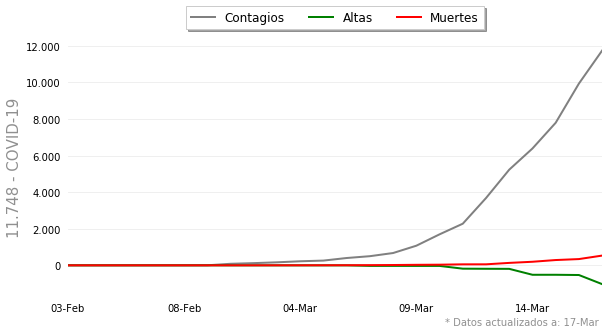

In [3]:
query = [{'Tabla':'time_series_19-covid-Confirmed'
         ,'Campo':'Contagios'}
        ,{'Tabla':'time_series_19-covid-Recovered'
         ,'Campo':'Altas'}
        ,{'Tabla':'time_series_19-covid-Deaths'
         ,'Campo':'Muertes'}] 

df = getDatos(query[0])
for i in range(len(query) - 1): 
    df = pd.merge(df, getDatos(query[i + 1]), on='Fecha')
    
df.loc[df['Fecha'] == '12-Mar', query[0]['Campo']] = 3680
df.loc[df['Fecha'] == '12-Mar', query[1]['Campo']] = 84
df.loc[df['Fecha'] == '12-Mar', query[1]['Campo']] = 189

df.Altas = df.Altas * -1
CrearGrafico(df, 'COVID-19')